In [1]:

import pandas as pd
import numpy as np
import metapack as mp
from pathlib import Path
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
from sdipylib.plot import  source_attribution

# /Users/eric/opt/anaconda3/envs/data/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
# The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
#   layout[ax.rowNum, ax.colNum] = ax.get_visible()
import warnings
warnings.simplefilter("ignore")

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

%run ../pylib/weights.py
%run lib.py 

source = "Survey of Consumer Finances, 2016 and 2019 pooled"



In [2]:
pkg = mp.jupyter.open_package()
#pkg = mp.jupyter.open_source_package()
pkg

# Survey of Consumer Finances, Inheritance Extract
`federalreserve.gov-consumer_finances-2016e2019-inherit-1.2.4` Last Update: 2020-12-08T05:15:35

_An Extract from the survey of consumer finances for studying networth and ineritance, from multiple years_


This is an extract of the 2016 and 2019 Survey of Consumer Finances, with extracted variables
and recoded variables oriented toward studying inheritance.


 
## Images

[![doc_img](docs/networth_race_inc.png "networth_race_inc")](docs/networth_race_inc.png)

Net Worth by Income Percentile and Race## Notes

* Version 1.2.2 Added the Inflatable flag
* Version 1.2.3 Inflated dollar ammounts to current dollars
## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [inherit_scf_16_19](data/inherit_scf_16_19.csv)**. Extract of the 2016 and 2019 SCF for inheritance and networth

## References
<ul><li> <strong>scf</string>, <em>metapack+http://library.metatab.org/federalreserve.gov-consumer_finances-1.1.1.csv</em>. Survey of consumer finances data packages</li><li> <strong><a href="https://fred.stlouisfed.org/graph/fredgraph.csv?&id=CPIAUCSL">cpi</a></strong>. Consumer Price Index</li><ul>

In [4]:
df = pkg.resource('inherit_scf_16_19').dataframe()
df = df[df.race.isin(['white','black'])]

# Count parent's bachelors degrees

def count_bach(r):
    return \
        int(r.ed_father_1 == 'bachelors') + \
        int(r.ed_father_2 == 'bachelors') + \
        int(r.ed_mother_1 == 'bachelors') + \
        int(r.ed_mother_2 == 'bachelors')
 
df['n_bach'] = df.apply(count_bach, axis=1)
df['agecl'] = df.agecl.astype(pd.CategoricalDtype([ '<35', '35-44', '45-54', '55-64', '65-74', '>=75',], ordered=True))
df['edcl'] = df.edcl.astype(pd.CategoricalDtype(['No HS', 'HS/GED', 'Some College', 'College'], ordered = True))

# Remap the nwpctlecat category numbers to percentile numbers
m = dict(zip(list(sorted(df.nwpctlecat.unique())),'0 10 20 30 40 50 60 70 80 90 95 99'.split()))
df['nwpctlecat'] = df.nwpctlecat.replace(m)

dfs = df.sample(500_000,replace=True, weights=df.wt0)
dfs.head()

,year,case_id,record_id,implicate_id,age_1,age_2,hisp,race,addtional_race,unusual_income,...,any_transfer,any_inherit,hhsize,networthpc,assetpc,gi_pv_10,gi_pv_7,gi_pv_5,gi_value_cd,n_bach
6860,2016,1376,13761,1,41,0,5,white,5,2,...,1,0,1,2.884617e+05,3.562118e+05,442821.467927,381542.265506,345405.511317,293401.613934,1
6211,2016,1246,12462,2,59,59,5,black,5,3,...,0,0,2,5.056925e+05,5.944306e+05,0.000000,0.000000,0.000000,0.000000,0
37848,2019,1329,13294,4,79,71,5,white,5,1,...,1,1,2,1.192837e+06,1.192837e+06,874293.741230,649060.743830,531934.992662,382637.114462,0
3885,2016,781,7811,1,74,71,5,white,5,3,...,0,0,2,1.085467e+05,1.136420e+05,0.000000,0.000000,0.000000,0.000000,0
12039,2016,2412,24125,5,27,25,5,white,5,2,...,0,0,2,-5.152533e+02,1.333934e+04,0.000000,0.000000,0.000000,0.000000,1


In [5]:

o, gi_sum_bins = pd.qcut(dfs[dfs.gi_value_cd > 0].gi_value_cd, 10 , retbins = True)
gi_sum_bins[0] = 0 # So zero gets included in a bin
dfs['gi_value_cd_decile']  = pd.cut(dfs.gi_value_cd, gi_sum_bins, labels=False).fillna(0)

o, gi_sum_bins = pd.qcut(dfs[dfs.gi_value_cd > 0].gi_value_cd, 100 , retbins = True, duplicates='drop')
#gi_sum_bins[0] = 0 # So zero gets included in a bin
dfs['gi_value_cd_pctle']  = pd.cut(dfs.gi_value_cd, gi_sum_bins, labels=False).fillna(0)

o, gi_sum_bins = pd.qcut(dfs[dfs.networth > 0].networth, 100 , retbins = True, duplicates='drop')
#gi_sum_bins[0] = 0 # So zero gets included in a bin
dfs['networth_pctle']  = pd.cut(dfs.networth, gi_sum_bins, labels=False).fillna(0)


dfs90 = dfs[ (dfs.networth_pctle <= 90) & (dfs.nincpctle < 90) ] # Exclude those in top 10pct of gifts. 



9.398749489286404


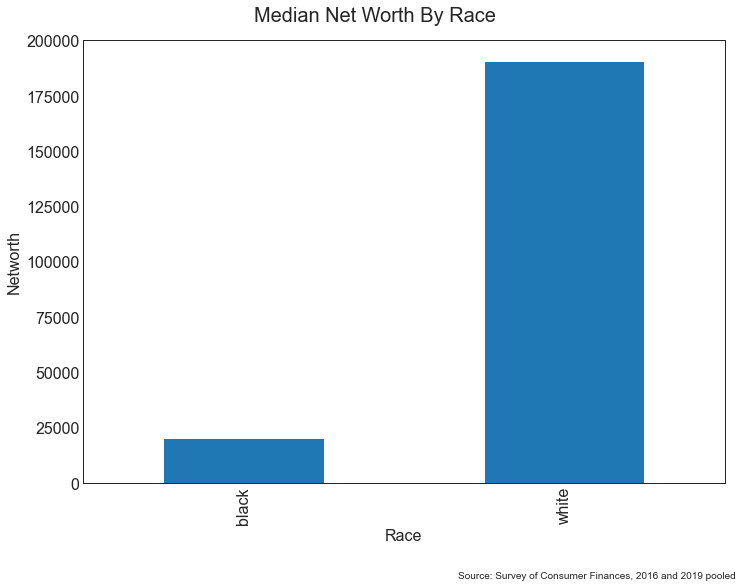

In [6]:
t = dfs.groupby('race').networth.median()
print(t.white/t.black)
    
with new_plot('Median Net Worth By Race', source,
             xlabel='Race', ylabel='Networth') as (fig,ax):
    
    t.plot.bar(ax=ax)

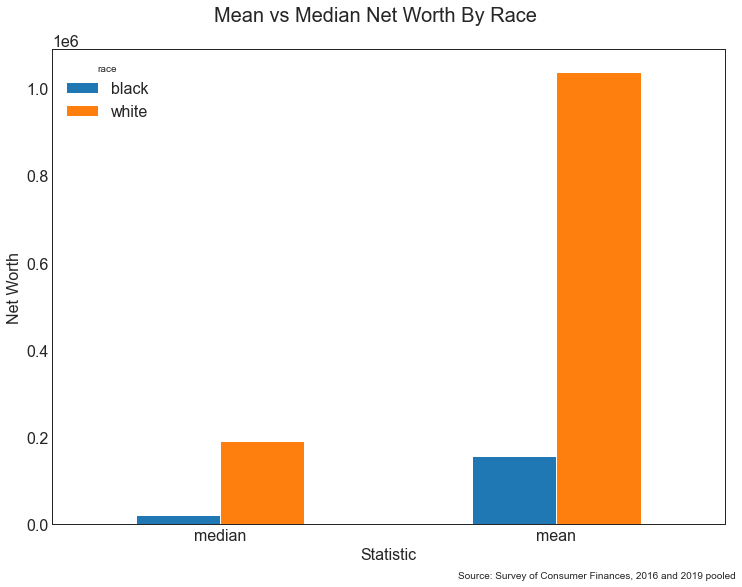

In [7]:

with new_plot('Mean vs Median Net Worth By Race', source,
             xlabel='Statistic', ylabel='Net Worth') as (fig,ax):
    a = dfs.groupby('race').networth.median().to_frame('median')
    #b = dfs90.groupby('race').networth.mean().to_frame('mean<90%')
    c = dfs.groupby('race').networth.mean().to_frame('mean')
    
    t = a.join(c)
    
    t.T.plot.bar(ax=ax)
    plt.xticks(rotation=0) 

    

If you want to show a large ratio you use the median, and if you want to show a large difference, you use the mean. 

However, when there are a small number of records in a group, the median have be very noisy, where the mean is more stable. 


In [8]:
(t.loc['white']/t.loc['black']).to_frame('ratio').round(2)\
    .join((t.loc['white']-t.loc['black']).to_frame('difference').round(-3).astype(int))

,ratio,difference
median,9.40,170000
mean,6.66,882000


In [9]:
t.loc['white']-t.loc['black']

median    170257.460045
mean      881544.365701
dtype: float64

The reason for the difference between the median and the mean is that income is strongly skewed to the higher end. THe top 1% ears a lot more money then the lower groups. 

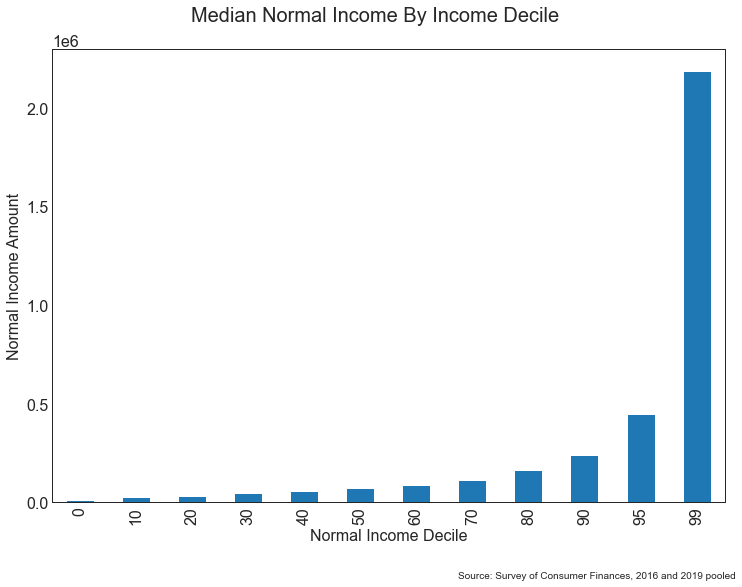

In [10]:

with new_plot('Median Normal Income By Income Decile', source,
             xlabel='Normal Income Decile', ylabel='Normal Income Amount') as (fig,ax):
    dfs.groupby('nincpctle').norminc.mean().plot.bar(ax=ax);


In [11]:
a = dfs[dfs.nincpctle>=90].networth.sum()
b = dfs[dfs.nincpctle<90].networth.sum()
a/(a+b)


0.6562583118642649

In [12]:
a = dfs[dfs.nincpctle>=99].networth.sum()
b = dfs[dfs.nincpctle<99].networth.sum()
a/(a+b)

0.2998184477118231

Wealth inequality is primarily non-racial; the top earners have a disproportionate share of the income and the wealth.

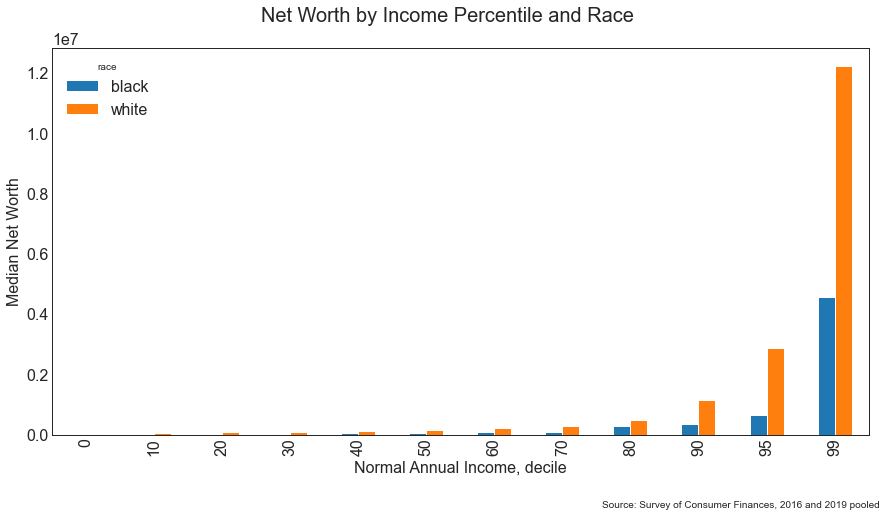

In [13]:
with new_plot('Net Worth by Income Percentile and Race', source, figsize=(12,7),
             xlabel='Normal Annual Income, decile', ylabel='Median Net Worth') as (fig,ax):
    t = dfs.groupby(['nincpctle', 'race']).networth.median().unstack()
    t.plot.bar(ax=ax)


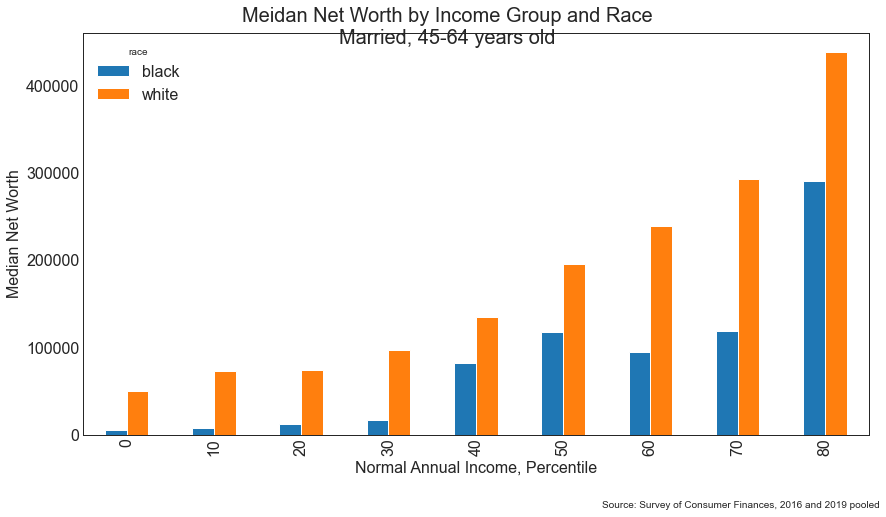

In [14]:
with new_plot('Meidan Net Worth by Income Group and Race\nMarried, 45-64 years old', 
              source, figsize=(12,7),
             xlabel='Normal Annual Income, Percentile', ylabel='Median Net Worth') as (fig,ax):
    t = dfs90
    t = t[(t.hhsize == 2) & (t.agecl.isin(['45-54','55-64']))  ]

    t.groupby(['nincpctle', 'race']).networth.median().unstack().plot.bar(ax=ax)

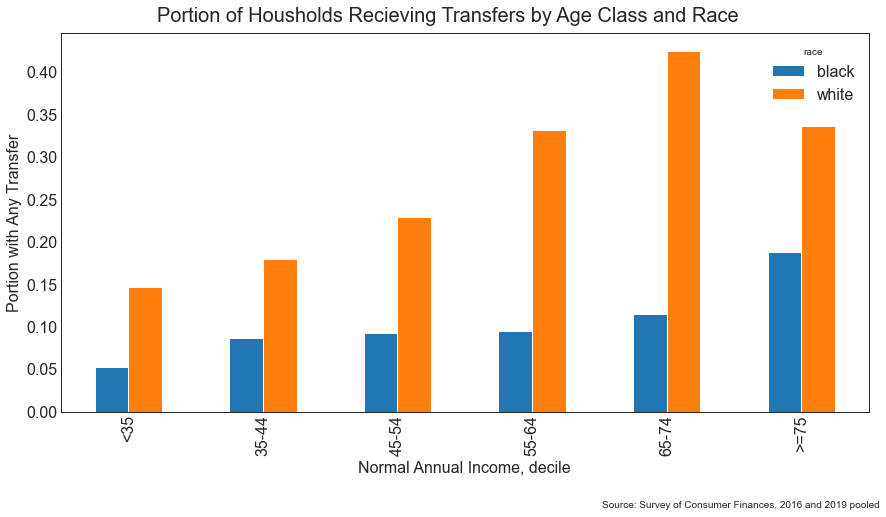

In [15]:
with new_plot('Portion of Housholds Recieving Transfers by Age Class and Race',
              source, figsize=(12,7),
             xlabel='Normal Annual Income, decile', ylabel='Portion with Any Transfer') as (fig,ax):
    
    t = dfs.groupby(['agecl','race']).any_transfer.mean().unstack().plot.bar(ax=ax)


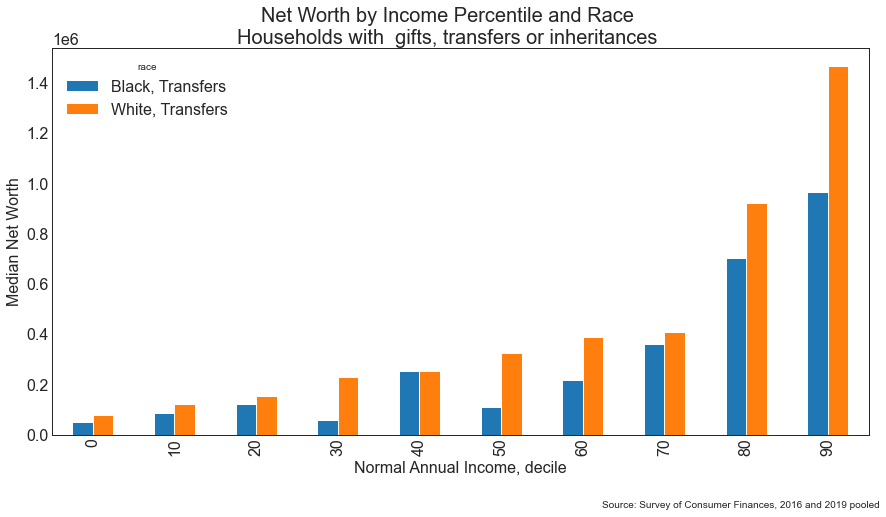

In [16]:
with new_plot('Net Worth by Income Percentile and Race\nHouseholds with  gifts, transfers or inheritances',
              source, figsize=(12,7),
             xlabel='Normal Annual Income, decile', ylabel='Median Net Worth') as (fig,ax):
    
    nh = dfs[dfs.gi_sum == 0]  # "no help"
    yh = dfs[dfs.gi_sum != 0] # " Yes help"
    
    t = yh[yh.nincpctle<95].groupby(['nincpctle','race']).networth.median().unstack()

    t.rename(columns={'white':'White, Transfers', 'black':'Black, Transfers'}).plot.bar(ax=ax)
    


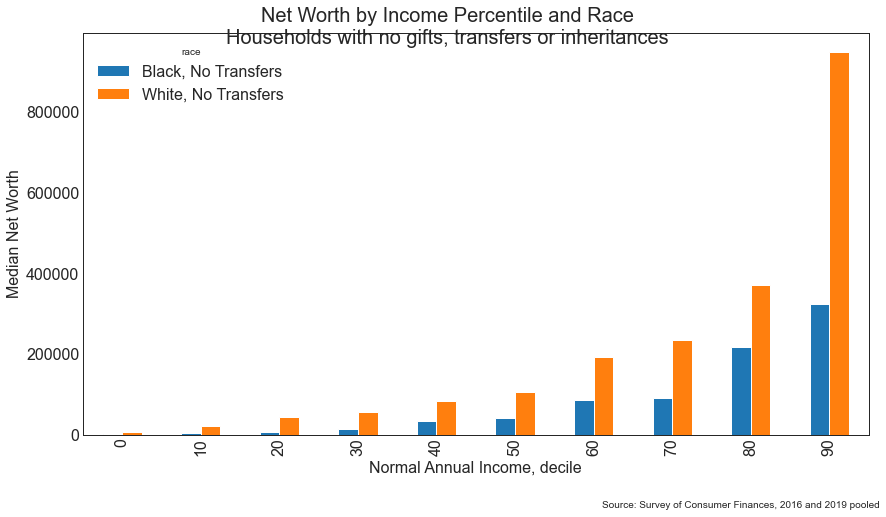

In [17]:
with new_plot('Net Worth by Income Percentile and Race\nHouseholds with no gifts, transfers or inheritances',
              source, figsize=(12,7),
             xlabel='Normal Annual Income, decile', ylabel='Median Net Worth') as (fig,ax):
    
    nh = dfs[dfs.gi_sum == 0]  # "no help"
    yh = dfs[dfs.gi_sum != 0] # " Yes help"
    
    t = nh[nh.nincpctle<95].groupby(['nincpctle','race']).networth.median().unstack()

    t.rename(columns={'white':'White, No Transfers', 'black':'Black, No Transfers'}).plot.bar(ax=ax)
    

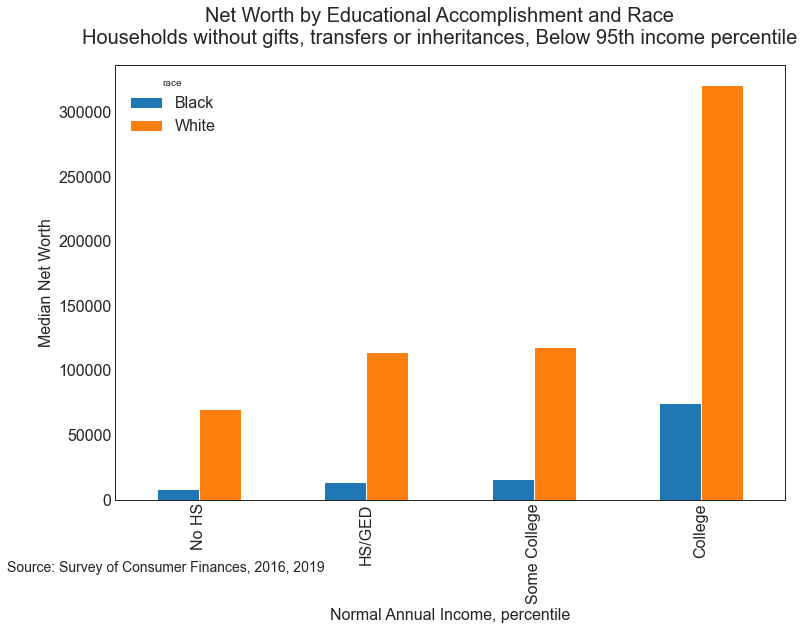

In [18]:
fig, ax = plt.subplots(figsize=(12,8))

fig.suptitle('Net Worth by Educational Accomplishment and Race\nHouseholds without gifts, transfers or inheritances, Below 95th income percentile', fontsize=20)
t = dfs[dfs.nincpctle < 95]
t = t.groupby(['edcl','race']).networth.median().unstack()

t.rename(columns={'white':'White', 'black':'Black'}).plot.bar(ax=ax)
plt.gcf().text(0,0, f"Source: Survey of Consumer Finances, 2016, 2019", fontsize=14) 
ax.set_xlabel('Normal Annual Income, percentile')
ax.set_ylabel('Median Net Worth');


TypeError: '<' not supported between instances of 'str' and 'int'

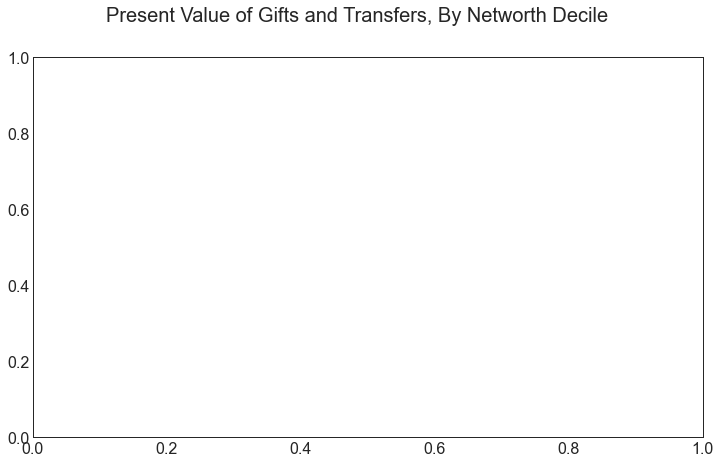

In [19]:

with new_plot('Present Value of Gifts and Transfers, By Networth Decile', source, figsize=(12,7),
             xlabel='Networth Decile', ylabel='Mean Transfer Value') as (fig,ax):
    t = dfs[(dfs.hhsize == 2) & 
            (dfs.agecl.isin(['45-54','55-64'])) &
            (dfs.edcl=='College') &
            (dfs.nincpctle<95) & 
            (dfs.nwpctlecat<10)]
    #t.groupby('nwpctle').gi_value_cd.mean().plot.bar(ax=ax)
    t.groupby('gi_value_cd_decile').networth.mean().plot.bar(ax=ax)


In [ ]:
sns.scatterplot(data=dfs90, x='networth_pctle', y='gi_value_cd_pctle');

t=dfs[['networth_pctle','gi_value_cd_pctle']].dropna()
t.corr()

In [ ]:
t = df.groupby(['ninccat','edcl','race']).networth.median().unstack()
t = t.black/t.white
t.unstack().plot()

# Role of Stocks and Home Equity

In [ ]:
t = dfs[dfs.n_transfer==0].copy()
t['house_r'] = t.homeeq/t.asset
t['eq_r'] = t.equity/t.asset
t['other_r'] = (t.asset-t.equity-t.homeeq)/t.asset
t['nfin_r'] = t.nfin/t.asset
t[['asset','networth','house_r', 'eq_r','other_r', 'nfin_r']].corr()

fig, ax = plt.subplots(2,2, figsize=(15,10))
ax = list(ax.flat)

g = t[t.nincpctle<99].groupby(['race','nincpctle'])

g.eq_r.mean().unstack().T.plot.bar(ax=ax[0]); ax[0].set_title('Equities', fontsize=16)
g.house_r.mean().unstack().T.plot.bar(ax=ax[1]); ax[1].set_title('Home Equity', fontsize=16)
g.other_r.mean().unstack().T.plot.bar(ax=ax[2]); ax[2].set_title('Other Assets ( Excl home and equities )', fontsize=16)
g.nfin_r.mean().unstack().T.plot.bar(ax=ax[3]); ax[3].set_title('Non Financial', fontsize=16)
fig.suptitle("Portion of Assets in Type of Asset, by Race and Income Percentile\nNo Transfers ", fontsize=20)

plt.tight_layout()
plt.subplots_adjust(top=0.90)

In [ ]:
t = nh.copy()
t['he_nfin_r'] = (t.homeeq+t.equity)/ (t.homeeq+t.equity+t.nfin)
g = t[t.nincpctle<95].groupby(['race','nincpctle'])
g.homeeq.mean().unstack().T.plot.bar()

In [ ]:
t = nh.copy()
t = t[ (t.nincpctle < 90) & (t.homeeq > 0) & (t.gi_sum == 0) & (t.married==2)]
g = t[t.nincpctle<95].groupby(['race','nincpctle'])
t = g.networth.median().unstack().T
t.plot.bar()

In [ ]:
(t.black/t.white).plot.bar()

In [ ]:
t = nh.copy()
#t = t[ (t.nincpctle < 90) & (t.homeeq > 0) & (t.gi_sum == 0) & (t.married==2)]
g = t[t.nincpctle<95].groupby(['race','nincpctle'])
t = g.networth.median().unstack().T

(t.black/t.white).plot.bar()

In [ ]:
t = dfs[dfs.age_1 <45].groupby(['nincpctle','race']).any_transfer.mean().unstack() 
t

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

fig.suptitle('Percentage recieving a Transfer, By Age and Race', fontsize=20)

t = (dfs.groupby(['race', 'agecl']).any_transfer.mean()*100).round(0).unstack().T

t.plot.bar(ax=ax)
plt.gcf().text(0,0, f"Source: Survey of Consumer Finances, 2016", fontsize=14) 
ax.set_xlabel('Age range')
ax.set_ylabel('Percentage that have recieved a transfer');

